In [1]:
import tensorflow as tf
import numpy as np
from PIL import Image
from scipy.optimize import fmin_l_bfgs_b
from scipy.misc import imsave
import time

In [2]:
height = 300
width = 300

In [3]:
content_image_path = './imgs/bit-mesra.jpg'

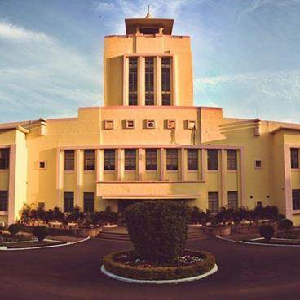

In [4]:
content_image = Image.open(content_image_path)
content_image = content_image.resize((height,width))
content_image

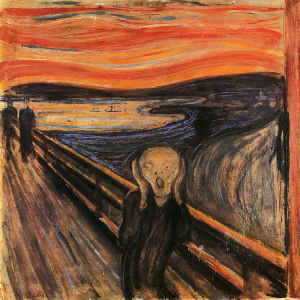

In [5]:
style_image = Image.open('./imgs/the-scream.jpg')
style_image = style_image.resize((height,width))
style_image

In [6]:
content_array = np.asarray(content_image, dtype='float32')
content_array = np.expand_dims(content_array,axis=0)
print(content_array.shape)

(1, 300, 300, 3)


In [7]:
style_array = np.asarray(style_image,dtype=np.float32)
style_array = np.expand_dims(style_array,axis=0)
print(style_array.shape)

(1, 300, 300, 3)


In [8]:
content_array[:, :, :, 0] -= 103.939
content_array[:, :, :, 1] -= 116.779
content_array[:, :, :, 2] -= 123.68
content_array = content_array[:, :, :, ::-1]

style_array[:, :, :, 0] -= 103.939
style_array[:, :, :, 1] -= 116.779
style_array[:, :, :, 2] -= 123.68
style_array = style_array[:, :, :, ::-1]

In [9]:
content_image = tf.keras.backend.variable(content_array)
style_image = tf.keras.backend.variable(style_array)
combination_image = tf.keras.backend.placeholder((1,height,width,3))

In [10]:
input_tensor = tf.keras.backend.concatenate([content_image,style_image,combination_image],axis=0)

In [11]:
model = tf.keras.applications.VGG16(input_tensor=input_tensor,include_top=False,weights='imagenet')

In [12]:
layers = dict([(layer.name,layer.output) for layer in model.layers])
layers

{'input_1': <tf.Tensor 'concat:0' shape=(3, 300, 300, 3) dtype=float32>,
 'block1_conv1': <tf.Tensor 'block1_conv1/Relu:0' shape=(3, 300, 300, 64) dtype=float32>,
 'block1_conv2': <tf.Tensor 'block1_conv2/Relu:0' shape=(3, 300, 300, 64) dtype=float32>,
 'block1_pool': <tf.Tensor 'block1_pool/MaxPool:0' shape=(3, 150, 150, 64) dtype=float32>,
 'block2_conv1': <tf.Tensor 'block2_conv1/Relu:0' shape=(3, 150, 150, 128) dtype=float32>,
 'block2_conv2': <tf.Tensor 'block2_conv2/Relu:0' shape=(3, 150, 150, 128) dtype=float32>,
 'block2_pool': <tf.Tensor 'block2_pool/MaxPool:0' shape=(3, 75, 75, 128) dtype=float32>,
 'block3_conv1': <tf.Tensor 'block3_conv1/Relu:0' shape=(3, 75, 75, 256) dtype=float32>,
 'block3_conv2': <tf.Tensor 'block3_conv2/Relu:0' shape=(3, 75, 75, 256) dtype=float32>,
 'block3_conv3': <tf.Tensor 'block3_conv3/Relu:0' shape=(3, 75, 75, 256) dtype=float32>,
 'block3_pool': <tf.Tensor 'block3_pool/MaxPool:0' shape=(3, 37, 37, 256) dtype=float32>,
 'block4_conv1': <tf.Tensor

In [13]:
content_weight = 2.0
style_weight = 2.0
total_variation_weight = 1.0

In [14]:
loss = tf.keras.backend.variable(0.)

In [15]:
def content_loss(content,combination):
    return tf.reduce_sum(tf.square(tf.subtract(content,combination)))

In [16]:
layer_features = layers['block2_conv2']
content_image_features = layer_features[0,:,:,:]
combination_features = layer_features[2,:,:,:]

loss = loss+content_weight*content_loss(content_image_features,combination_features)

In [17]:
def gram_matrix(x):
    features = tf.keras.backend.batch_flatten(tf.keras.backend.permute_dimensions(x, (2, 0, 1)))
    gram = tf.keras.backend.dot(features, tf.keras.backend.transpose(features))
    return gram

In [18]:
def style_loss(style,combination):
    s = gram_matrix(style)
    c = gram_matrix(combination)
    channels = 3
    size = height*width
    return tf.reduce_sum(tf.square(s-c))/(4.0*(channels*width)**2)

In [19]:
feature_layers = ['block1_conv2', 'block2_conv2',
                  'block3_conv3', 'block4_conv3',
                  'block5_conv3']

In [20]:
for layer_name in feature_layers:
    layer_features = layers[layer_name]
    style_feature = layer_features[1,:,:,:]
    combination_features = layer_features[2,:,:,:]
    sl = style_loss(style_feature,combination_features)
    loss = loss+(style_weight / len(feature_layers)) * sl

In [21]:
def total_variation_loss(x):
    a = tf.square(x[:, :height-1, :width-1, :] - x[:, 1:, :width-1, :])
    b = tf.square(x[:, :height-1, :width-1, :] - x[:, :height-1, 1:, :])
    return tf.reduce_sum(tf.pow(a + b, 1.25))

In [22]:
loss = loss+total_variation_weight * total_variation_loss(combination_image)

In [23]:
grads = tf.keras.backend.gradients(loss, combination_image)

In [24]:
outputs = [loss]
outputs = outputs+grads
f_outputs = tf.keras.backend.function([combination_image], outputs)

In [25]:
def eval_loss_and_grads(x):
    x = x.reshape((1, height, width, 3))
    outs = f_outputs([x])
    loss_value = outs[0]
    grad_values = outs[1].flatten().astype('float64')
    return loss_value, grad_values

In [26]:
class Evaluator(object):

    def __init__(self):
        self.loss_value = None
        self.grads_values = None

    def loss(self, x):
        assert self.loss_value is None
        loss_value, grad_values = eval_loss_and_grads(x)
        self.loss_value = loss_value
        self.grad_values = grad_values
        return self.loss_value

    def grads(self, x):
        assert self.loss_value is not None
        grad_values = np.copy(self.grad_values)
        self.loss_value = None
        self.grad_values = None
        return grad_values

In [27]:
evaluator = Evaluator()

In [28]:
xyz = Image.open(content_image_path)
xyz = xyz.resize((height,width))
xyz = np.asarray(xyz, dtype='float32')
x = np.expand_dims(xyz,axis=0)
x[:, :, :, 0] -= 103.939
x[:, :, :, 1] -= 116.779
x[:, :, :, 2] -= 123.68
x = x[:, :, :, ::-1]
#x = np.random.uniform(0, 255, (1, height, width, 3)) - 128.

In [29]:
iterations = 10

In [30]:
for i in range(iterations):
    print('Start of iteration', i)
    start_time = time.time()
    x, min_val, info = fmin_l_bfgs_b(evaluator.loss, x.flatten(),
                                     fprime=evaluator.grads, maxfun=20)
    print('Current loss value:', min_val)
    end_time = time.time()
    print('Iteration %d completed in %ds' % (i, end_time - start_time))

Start of iteration 0
Current loss value: 219839600000000.0
Iteration 0 completed in 50s
Start of iteration 1
Current loss value: 66208292000000.0
Iteration 1 completed in 24s
Start of iteration 2
Current loss value: 33229201000000.0
Iteration 2 completed in 24s
Start of iteration 3
Current loss value: 21941929000000.0
Iteration 3 completed in 24s
Start of iteration 4
Current loss value: 16594833000000.0
Iteration 4 completed in 24s
Start of iteration 5
Current loss value: 13427420000000.0
Iteration 5 completed in 24s
Start of iteration 6
Current loss value: 11234050000000.0
Iteration 6 completed in 29s
Start of iteration 7
Current loss value: 9727653000000.0
Iteration 7 completed in 26s
Start of iteration 8
Current loss value: 8514888500000.0
Iteration 8 completed in 28s
Start of iteration 9
Current loss value: 7569220300000.0
Iteration 9 completed in 27s


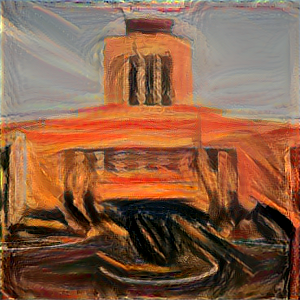

In [31]:
x = x.reshape((height, width, 3))
x = x[:, :, ::-1]
x[:, :, 0] += 103.939
x[:, :, 1] += 116.779
x[:, :, 2] += 123.68
x = np.clip(x, 0, 255).astype('uint8')

Image.fromarray(x)